In [17]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
%matplotlib inline
print("Using PyTorch Version %s" %torch.__version__)

Using PyTorch Version 1.0.0


In [18]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [19]:
np.random.seed(0)
torch.manual_seed(0)
X, Y = make_moons(500, noise=0.2)

# Split into test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
    test_size=0.25, random_state=73)

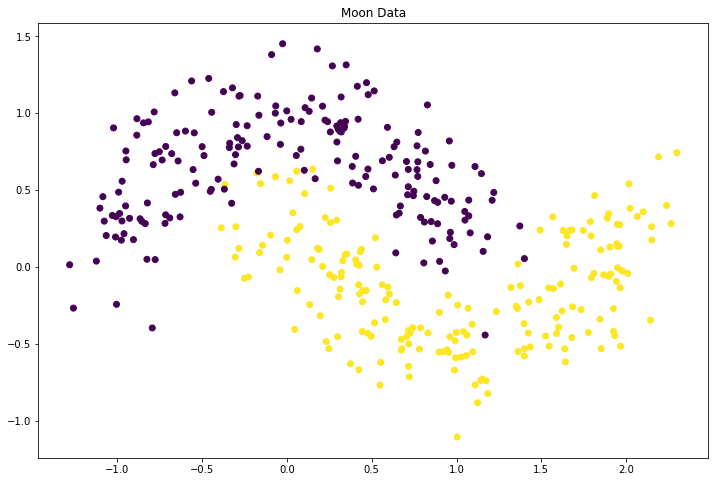

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title('Moon Data')
plt.show()

In [21]:
# Define network dimensions
n_input_dim = X_train.shape[1]
# Layer size
n_hidden = 4 # Number of hidden nodes
n_output = 1 # Number of output nodes = for binary classifier

# Build your network
net = nn.Sequential(
    nn.Linear(n_input_dim, n_hidden),
    nn.ELU(),
    nn.Linear(n_hidden, n_output),
    nn.Sigmoid())
    
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


In [26]:
x = torch.FloatTensor([1, 1])
net(x.to(device="cuda"))

tensor([0.4359], grad_fn=<SigmoidBackward>)

In [27]:
net.cuda()
x = torch.FloatTensor([1, 1]).to(device='cuda')
net(x)

tensor([0.4359], grad_fn=<SigmoidBackward>)

In [28]:
loss_func = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

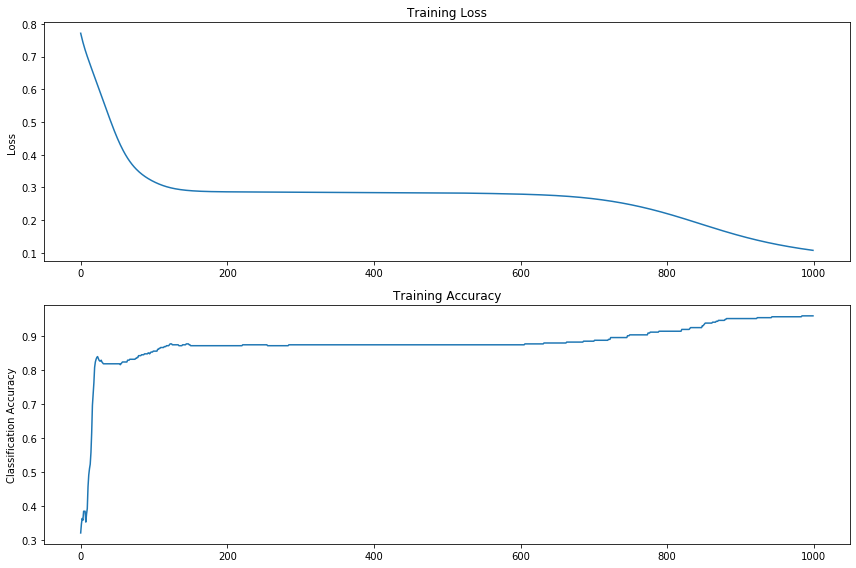

In [32]:
train_loss = []
train_accuracy = []
iters = 1000
Y_train_t = torch.FloatTensor(Y_train).reshape(-1, 1)
for i in range(iters):
    X_train_t = torch.FloatTensor(X_train)
    y_hat = net(X_train_t.to(device="cuda"))
    loss = loss_func(y_hat, Y_train_t.to(device="cuda"))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    y_hat_class = np.where(y_hat.cpu().detach().numpy()<0.5, 0, 1)
    accuracy = np.sum(Y_train.reshape(-1,1)==y_hat_class) / len(Y_train)
    train_accuracy.append(accuracy)
    train_loss.append(loss.item())
    
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

Test Accuracy 0.93


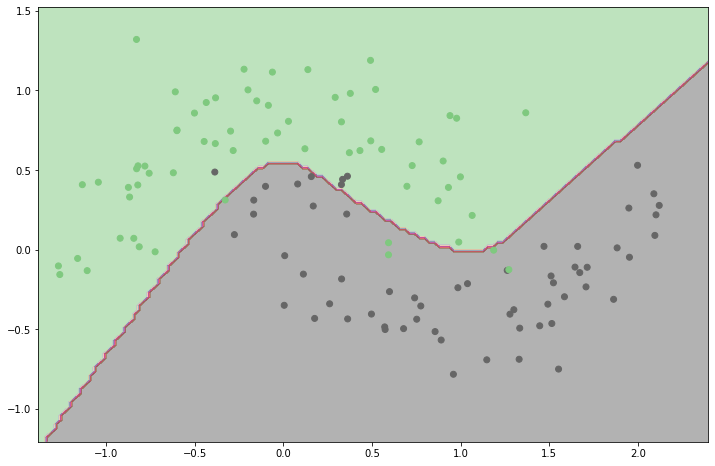

In [43]:
# Pass test data
X_test_t = torch.FloatTensor(X_test)
y_hat_test = net(X_test_t.to(device="cuda"))
y_hat_test_class = np.where(y_hat_test.cpu().detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(Y_test.reshape(-1,1)==y_hat_test_class) / len(Y_test)
print("Test Accuracy {:.2f}".format(test_accuracy))

# Plot the decision boundary
# Determine grid range in x and y directions
x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

# Set grid spacing parameter
spacing = min(x_max - x_min, y_max - y_min) / 100

# Create grid
XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))

# Concatenate data to match input
data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))

# Pass data to predict method
data_t = torch.FloatTensor(data)
db_prob = net(data_t.to(device="cuda"))

clf = np.where(db_prob.cpu()<0.5,0,1)

Z = clf.reshape(XX.shape)

plt.figure(figsize=(12,8))
plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, 
            cmap=plt.cm.Accent)
plt.show()